<a href="https://colab.research.google.com/github/yabbou/python-data-science/blob/main/hw_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Power Plant Predictions**
==

This notebook deals with the task of constructing a **cross-validated linear regression model** to predict the power plant energy production. The data used for this task has been obtained from the UC Irvine Machine Learning archive [here](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant).

The data set is comprised of nearly ten thousand observations of one response variable (`energy output`) and four explanatory variables (`temperature`, `ambient pressure`, `relative humidity`, and `exhaust vacuum`). The observations were collected from a **Combined Cycle Power Plant** (CCPP) over 6 years (2006-2011).

A CCPP is built of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. Its electricity is generated by those turbines in a single cycle, and is transferred between turbines. Of the four independent, explanatory variables, `exhaust vacuum` effects ST performance, while `temperature`, `ambient pressure`, and `relative humidity` effect the GT performance.

####__Question:__ What combination of factors will produce a higher, more effective power plant energy output? 

Here is a sample of the data:

In [ ]:
import numpy as np
import pandas as pd 

power_df = pd.read_csv("https://raw.githubusercontent.com/yabbou/python-data-science/main/hw_3/Power_Plant.csv")
power_df = power_df.rename(columns={'T':'Temperature',
                                    'V':'Exhaust_vacuum',
                                    'AP':'Ambient_pressure',
                                    'RH':'Relative_humidity',
                                    'EP':'Net_hourly_electrical_energy_output'})
power_df.head(3)

,Temperature,Exhaust_vacuum,Ambient_pressure,Relative_humidity,Net_hourly_electrical_energy_output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56


Any null values?

In [ ]:
power_df.isnull().sum()

Temperature                            0
Exhaust_vacuum                         0
Ambient_pressure                       0
Relative_humidity                      0
Net_hourly_electrical_energy_output    0
dtype: int64

None.

EDA
==
Now, what does this numeric data look like visually?

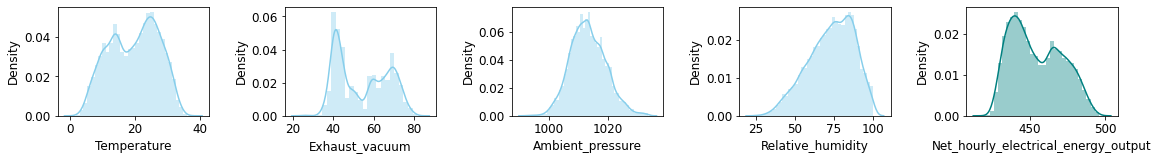

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
figure, axes = plt.subplots(1, 5)

sns.distplot(power_df["Temperature"], color="skyblue", ax=axes[0])
sns.distplot(power_df["Exhaust_vacuum"], color="skyblue", ax=axes[1])
sns.distplot(power_df["Ambient_pressure"], color="skyblue", ax=axes[2])
sns.distplot(power_df["Relative_humidity"], color="skyblue", ax=axes[3])
sns.distplot(power_df["Net_hourly_electrical_energy_output"], color="teal", ax=axes[4])

plt.rcParams.update({'font.size': 12,'figure.figsize':(19,2)}) 
plt.subplots_adjust(hspace=.3, wspace=.5)
plt.show()


* `Temperature` appears to have a bimodal distribution, dividing its values into two groups.
* `Exhaust vacuum` also appears bimodal.
* `Ambient pressure` has a normal distribution, with a single group symmertic about its mean.
* `Relative humidity` has a left skewed distribution.

The resultant `net hourly electrical energy output` has a **bimodal distribution**. Hence `temperature` and `exhaust vacuum` seem to have a larger impact on the net energy output trends.

Do some factors cause or correlate with higher values of other factors? How do the factors independently correlate with the net energy output?

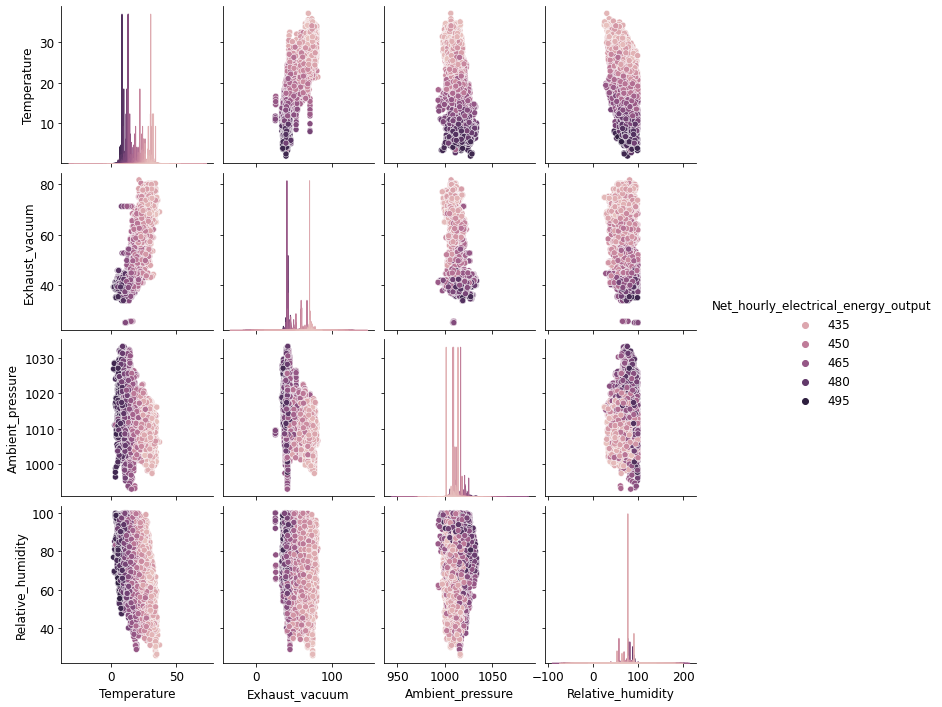

In [11]:
sns.pairplot(power_df, hue='Net_hourly_electrical_energy_output')

The factors appear do not appear to correlate to much with each other. _All_ the factor correlations graph vertically: high and low values of one factor correlate both to high and low values of the other factor. Though, 

* `Temperature` and `exhasust vaccum` seem to increase together, slightly. 
* `Temperature` seems to correlate with the highest `energy output` values (when correlated with itself) compared to the other factors. 
* Higher `energy outputs` do very linearly lean to certain higher/lower factor values, depending on the factor. 

Lets's analyse those more closely. 

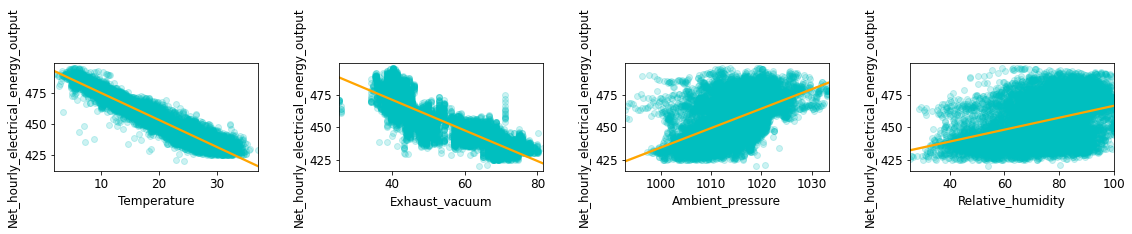

In [14]:
figure, axes = plt.subplots(1, 4)

energy_output = power_df["Net_hourly_electrical_energy_output"]
sns.regplot(power_df["Temperature"],energy_output, color="c", scatter_kws={'alpha': 0.2},line_kws={'color': 'orange'}, ax=axes[0])
sns.regplot(power_df["Exhaust_vacuum"],energy_output, color="c", scatter_kws={'alpha': 0.2},line_kws={'color': 'orange'}, ax=axes[1])
sns.regplot(power_df["Ambient_pressure"],energy_output, color="c", scatter_kws={'alpha': 0.2},line_kws={'color': 'orange'}, ax=axes[2])
sns.regplot(power_df["Relative_humidity"],energy_output, color="c", scatter_kws={'alpha': 0.2},line_kws={'color': 'orange'}, ax=axes[3])

plt.rcParams.update({'font.size': 12,'figure.figsize':(21,4)}) 
plt.subplots_adjust(hspace=.3, wspace=.4)
plt.show()

* `Temperature` linearly correlates with the net energy output: the lower the temperature, the higher the output.
* `Exhaust vaccum` has a similar inverse correlation, though lower exhaust vaccum values appear slightly more common in the downward trend.
* `Ambient pressure` has an overall parallel correlation with energy output: the higher the ambient pressure, the higher the energy output. Though, the values appear vertically placed, suggesting a less direct correlation; high output could be found frequently with lower ambient pressure values as with higher ones. 
* `Relative humidity` appears to have the least correlation. Overall there is a gradual parallel incline, increasing output as relative humidity increases, but spans the lowest range of the lower `output` values.

What are the general stats these graphs are displaying?

In [15]:
power_df.describe()

,Temperature,Exhaust_vacuum,Ambient_pressure,Relative_humidity,Net_hourly_electrical_energy_output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Prediction Models
==


####Let's try the first prediction model.


**OLS (Ordinary Least Squares) Regression** estimates the values of `m` and `b` in a manner *that minimizes the sum of the squares of the differences* between the given dependent variable values and the predicted dependent variable values. The prediction algorithm uses the slope formula for a straight line: `y = mx + b`. As usual, `x` is the independant and  `y` the dependent variable.

In [65]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

def olsRegression(test_size_decimal, equation):
  X = power_df.iloc[:,:-1]
  y = power_df.iloc[:,-1]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
  train_data = pd.concat([X_train, y_train], axis=1)

  model_ols = smf.ols(equation, data=train_data).fit()
  print(model_ols.summary())
  return model_ols, X_train, X_test, y_train, y_test 

TEMP_AND_EXHAUST = 'Net_hourly_electrical_energy_output ~ Temperature + Exhaust_vacuum'
model_ols, X_train, X_test, y_train, y_test = olsRegression(0.25,TEMP_AND_EXHAUST)

                                     OLS Regression Results                                    
Dep. Variable:     Net_hourly_electrical_energy_output   R-squared:                       0.915
Model:                                             OLS   Adj. R-squared:                  0.915
Method:                                  Least Squares   F-statistic:                 3.877e+04
Date:                                 Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                                         17:35:37   Log-Likelihood:                -21660.
No. Observations:                                 7176   AIC:                         4.333e+04
Df Residuals:                                     7173   BIC:                         4.335e+04
Df Model:                                            2                                         
Covariance Type:                             nonrobust                                         
                     coef    std err    

All of the probabilty statistics point towards an accurate prediction. Though, the skew is negative and the kertosis is above 3-- values of a **slightly right-skewed distribution**. 

Noteworthy statistics:
>**R-squared**: measurement of the accuracy of the regression. Out of 1, the higher the better.
>
>**Prob (F-statistic)**: the probability that coefficients of all factors would be zero. Below 0.5 (`50%`) suggests higher certainty in prediction.
>
>**Prob (t-statistic)**: ratio of deviation of the predicted value of a parameter and its standard error. 
>
>**Confidence interval [ 2.5% to 97.5% ]**: the range of future coefficent value prediction. The smaller the range, the more precise the model.
>
>**Prob (Omnibus)**: should be low.
>
>**Skew**: normal distribution is 0. 
>
>**Kertosis**: normal distribution around 3. 
>
>**Conditional Number**: above 30 means some columns are colinear.

Note: 
>(1) The column names must **not** be seperated by whitespace for the `.ols()` linear regresssion formula. One alternative is underscores between sepeate words.
>
> (2) In the `.ols()` linear regression equation, the dependant (response) variable is to the left of the tilda (~) and the independant variable(s) to its right.

How accurate is the prediction model? 

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def foldValidation(FOLDS,cols,X_train,y_train):
  ten_fold_scores = cross_val_score(LinearRegression(), X_train[cols], y_train, cv=FOLDS)

  # print(f'{FOLDS}-fold validation scores:')
  # print('--------------------------')
  # for f in range(FOLDS):
  #   print(f'Fold {f+1}: \t{ten_fold_scores[f]:.5f}')

  m = ten_fold_scores.mean()
  print(f'{FOLDS}-fold validation score average:',m)
  return m

TEMP_AND_EXHAUST_COLUMNS = ['Temperature','Exhaust_vacuum']
m = foldValidation(10,TEMP_AND_EXHAUST_COLUMNS,X_train,y_train)

10-fold validation score average: 0.915132721842836


The OLS regression method produced a cross validation score of `91.5%`. (Just like the R-squared statistic.)

The **Mean Squared Error** (MSE) can further assess a model's accuracy. The MSE measures the average **squared difference** (or squared residual) between the predicted values and the given values. See [here](https://drive.google.com/file/d/113yjM4Usjjt-cEsmIAvkw8JAv_k5I2BP/view?usp=sharing) for a related visual.

In [70]:
from sklearn import metrics

def mse(cols, model_ols,X_test, y_test):
  y_predicted_test = model_ols.predict(X_test[cols])
  res = metrics.mean_squared_error(y_test.T.squeeze(), y_predicted_test)
  return res

def displayMSE(res):
  print(f'Mean Squared Error: {res}')

res = mse(TEMP_AND_EXHAUST_COLUMNS,model_ols,X_test,y_test)
displayMSE(res)

Mean Squared Error: 24.670182537395046


Scores closer to zero correspond with estimated lower prediction error. The realtive accuracy of this model will be seen after compared to other models.


####Let's try a second prediction model.

In [58]:
model_ols, X_train, X_test, y_train, y_test = olsRegression(0.3,TEMP_AND_EXHAUST)

                                     OLS Regression Results                                    
Dep. Variable:     Net_hourly_electrical_energy_output   R-squared:                       0.915
Model:                                             OLS   Adj. R-squared:                  0.915
Method:                                  Least Squares   F-statistic:                 3.877e+04
Date:                                 Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                                         17:34:51   Log-Likelihood:                -21660.
No. Observations:                                 7176   AIC:                         4.333e+04
Df Residuals:                                     7173   BIC:                         4.335e+04
Df Model:                                            2                                         
Covariance Type:                             nonrobust                                         
                     coef    std err    

All the statistics are basically identiacal. The additional `5%` test data does not appear to alter the prediction results.

####Let's try different factors in the next model.

In [71]:
TEMP_AND_PRESSURE = 'Net_hourly_electrical_energy_output ~ Temperature + Ambient_pressure'
model_ols, X_train, X_test, y_train, y_test = olsRegression(0.3,TEMP_AND_PRESSURE)

                                     OLS Regression Results                                    
Dep. Variable:     Net_hourly_electrical_energy_output   R-squared:                       0.900
Model:                                             OLS   Adj. R-squared:                  0.899
Method:                                  Least Squares   F-statistic:                 3.211e+04
Date:                                 Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                                         17:38:20   Log-Likelihood:                -22274.
No. Observations:                                 7176   AIC:                         4.455e+04
Df Residuals:                                     7173   BIC:                         4.457e+04
Df Model:                                            2                                         
Covariance Type:                             nonrobust                                         
                       coef    std err  

The `R-squared` score is lower, from `91.5%` to `89.9%`. Skew and kurtosis indeed decreased... but the `JB Probability` test is tremendously negative (and zero is the desired value)!

In [60]:
TEMP_AND_PRESSURE_COLUMNS = ['Temperature','Ambient_pressure']
mean = foldValidation(10,TEMP_AND_PRESSURE_COLUMNS,X_train,y_train)

10-fold validation score average: 0.8992722993462303


An expected slightly lower cross validation score of `89.9%`.

In [72]:
res = mse(TEMP_AND_PRESSURE_COLUMNS, model_ols, X_test, y_test)
displayMSE(res)

Mean Squared Error: 28.331248787722245


Four points higher error than the first model's score of `24`. 

####How about a model including _every_ factor?

In [90]:
ALL_FACTORS = 'Net_hourly_electrical_energy_output ~ Temperature + Exhaust_vacuum + Ambient_pressure + Relative_humidity'
model_ols, X_train, X_test, y_train, y_test = olsRegression(0.25,ALL_FACTORS)
print()

ALL_FACTORS_COLS = ['Temperature','Exhaust_vacuum','Ambient_pressure','Relative_humidity']
ols_mean = foldValidation(10,ALL_FACTORS_COLS,X_train,y_train)
print()

ols_mse = mse(ALL_FACTORS_COLS,model_ols,X_test,y_test)
displayMSE(ols_mse)

                                     OLS Regression Results                                    
Dep. Variable:     Net_hourly_electrical_energy_output   R-squared:                       0.928
Model:                                             OLS   Adj. R-squared:                  0.928
Method:                                  Least Squares   F-statistic:                 2.321e+04
Date:                                 Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                                         18:44:38   Log-Likelihood:                -21063.
No. Observations:                                 7176   AIC:                         4.214e+04
Df Residuals:                                     7171   BIC:                         4.217e+04
Df Model:                                            4                                         
Covariance Type:                             nonrobust                                         
                        coef    std err 

Fascinating. The `R-squared` rating is the highest so far, with a predicted `92.8`% accuracy! `Kurtosis`, `skew`, and `MSE` have lowered. All the probability calcuations are at 0. (Yet the `conditional number` is quite large.) 

####How about the `sklearn` linear regression algorithm?

In [94]:
from sklearn.linear_model import LinearRegression

ALL_FACTORS = power_df.iloc[:,:-1] 
y = power_df.iloc[:,-1]

model_linear = LinearRegression().fit(ALL_FACTORS,y)
model_lin_score = model_linear.score(ALL_FACTORS, y)
print('SKLearn regression score:',model_lin_score)

diff = model_lin_score - ols_mean 
print(f'Difference of regression score (SKLearn, OLS): {round(diff*100,3)}%')

SKLearn regression score: 0.9286960898122536
Difference of regression score (SKLearn, OLS): 0.062%


The `SKLearn` regression algorithm is more effecient... though, by less than `1%`. 

In [96]:
linear_mse = mse(ALL_FACTORS_COLS,model_linear,X_test,y_test)
displayMSE(linear_mse)

Mean Squared Error: 20.814660767323627


Interstingly, the error MSE is greater (usually a sign of lower accuracy).

Conclusion
==

Regression using all of the variables had the highest probability of predicting accurate results. The `SKLearn` and `OLS` algorithms produced basically equivalent prediction model, expecting `92.58%` accuracy.